In [1]:
import torch
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg
from svetlanna import LinearOpticalSetup

from PIL import Image

## Создание расчетной сетки с использованием класса `SimulationParameters`

In [2]:
# размеры экрана, мм
lx = 8 * ureg.mm
ly = 8 * ureg.mm

# фокальное расстояние, мм
f = 100 * ureg.mm

# длина волны, нм
wavelength = 1064 * ureg.nm

# количество точек в расчетной сетке
Nx = 2048
Ny = 2048

# создание расчетной сетки
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [3]:

x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Создание плоской волны с использованием `svetlanna.wavefront.plane_wave`

Создадим плоскую волну, которая будет падать на систему:

In [4]:
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=10 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Подготовка изображения: конвертация в форму апертуры
В этой секции изображение `phystech_logo.png` будет конвертировано в маску, которой определяется функция пропускания апертуры.

In [5]:
# путь к изображению
image_path = '.\doc\phystech_logo.png'  # замените на путь к вашему изображению

# размер изображения
N, M = 256, 256

# Загрузка изображения
image = Image.open(image_path)

M = 256
# измененный размер изображения
image_resized = image.resize((N, M))  # Размеры указываются как (ширина, высота)

# преобразуем изображение в тензор
image_tensor = torch.tensor(
    data=list(image_resized.getdata()),
    dtype=torch.float64
).reshape(N, M, -1)

# нормализуем тензор изображения
if image_tensor.dtype == torch.uint8:
    image_tensor = image_tensor / 255.0

# выбираем только один канал (если изображение цветное)
image_tensor = image_tensor[:, :, 0]

# применяем бинаризацию
image_tensor = image_tensor >= 10

# Определяем координаты для вставки image_tensor в центр mask
start_x = (Nx - M) // 2
start_y = (Ny - N) // 2

mask = torch.zeros((Ny, Nx), dtype=torch.float64)

# помещаем image_tensor в центр mask
mask[start_y:start_y + N, start_x:start_x + M] = image_tensor

In [6]:
aperture = elements.Aperture(simulation_parameters=sim_params, mask=mask)

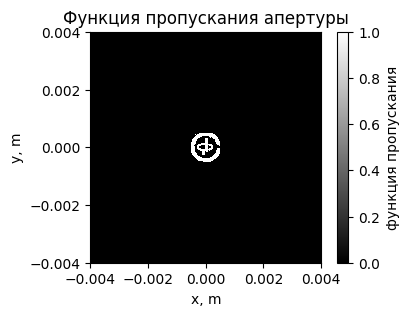

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

im = ax.pcolormesh(x_grid, y_grid, aperture.get_transmission_function(), cmap='gray')
ax.set_aspect('equal')
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
ax.set_title('Функция пропускания апертуры')
fig.colorbar(im, ax=ax, label='функция пропускания')

## Создание оптической системы

В этой секции будет создана численная модель оптической системы с использованием класса `LinearOpticalSetup` из модуля `svetlanna.setup`. Оптическая система состоит из апертуры, заданной функций пропускания, которая определяется объектом mask`, и тонкой собирающей линзы. Распространение волнового фронта между элементами будет рассчитано с использованием метода углового спектра из модуля `FreeSpace`

In [8]:
lens = elements.ThinLens(
    simulation_parameters=sim_params,
    focal_length=f,
    radius=100 * ureg.mm
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=f,
    method="AS"
)

setup = LinearOpticalSetup([aperture, free_space, lens, free_space])

## Расчет распределения интенсивности волнового фронта в задней фокальной плоскости тонкой линзы

Как известно, тонкая линза делает преобразование Фурье падающего на ее поверхность волнового фронта. Сравним распределение интенсивности, получившееся после прохождения оптической системы, и быстрое преобразование Фурье изображения, реализованное с помощью `torch.fft.fft2`

In [9]:
output_wavefront = setup.forward(input_wavefront=incident_field)
output_intensity = output_wavefront.intensity

In [10]:
fft = torch.fft.fftshift(torch.fft.fft2(mask))

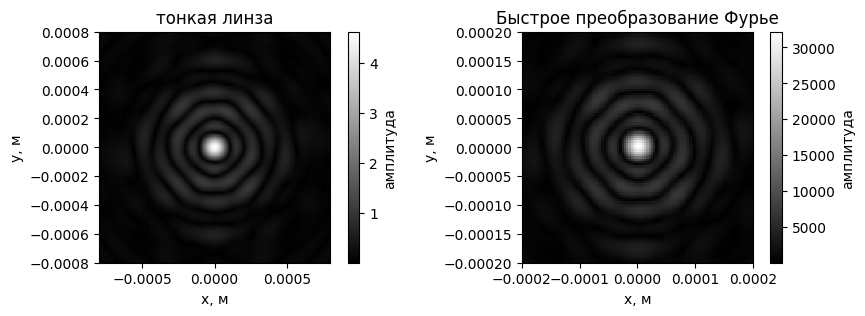

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
im0 = ax[0].pcolormesh(x_grid, y_grid, torch.sqrt(output_intensity), cmap='gray')
ax[0].set_aspect('equal')
ax[0].set_xlabel('x, м')
ax[0].set_ylabel('y, м')

ax[0].set_xlim(-lx / 10, lx / 10)
ax[0].set_ylim(-ly / 10, ly / 10)
ax[0].set_title('тонкая линза')
fig.colorbar(im0, ax=ax[0], label='амплитуда')

im1 = ax[1].pcolormesh(x_grid, y_grid, torch.abs(fft), cmap='gray')
ax[1].set_aspect('equal')
ax[1].set_xlabel('x, м')
ax[1].set_ylabel('y, м')

ax[1].set_xlim(-lx / 40, lx / 40)
ax[1].set_ylim(-ly / 40, ly / 40)
ax[1].set_title('Быстрое преобразование Фурье')
fig.colorbar(im1, ax=ax[1], label='амплитуда')